In [1]:
import tensorflow as tf
import math
import tensorflow_hub as hub
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import roc_curve
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#### 1. Değişkenlerin değerlerini belirledik.

In [2]:
train_examples = 20224
validation_examples = 2552
test_examples=2555
img_height = img_width = 224 # birçoğu 1000 pikselin üzerinde. Hepsiniz 224 pixele resize ediyoruz.
batch_size = 32

#### 2. CREATE MODEL: Modeli belirledik.

Kullanacağımız modeli belirleyeceğiz. Resnet kullanabiliriz, Inception Net, Efficent Net vs. kullanabiliriz. Biz [NasNet](https://tfhub.dev/google/imagenet/nasnet_mobile/feature_vector/5) adında bir model kullanacağız. Bu Tensorflow Hub'ın bir modeli.

In [3]:
model = keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/google/imagenet/nasnet_mobile/feature_vector/5", 
                   trainable=True), # bu modeli de eğiteceğiz biz
    # layers.Flatten() buna gerek yok zaten flatten edilmiş oluyor
    tf.keras.layers.Dense(1, activation='sigmoid') # num_classes yerine 1 yazdık, sadece 2 classımız olduğu için.
])

Dense layerdan önce başka layerlar da ekleyebilirdik.

#### 3. LOAD DATASET: Custom olan verimizi alabilmek için ImageDataGenerator kullanıyoruz. 

Bunu farklı şekilde de load edebilirdik `dataset_from_directory` kullanarak. [18. TensorFlow Tutorial 18 - Custom Dataset for Images.ipynb](https://github.com/eliffkkurt/MyRoadmap/blob/main/TensorFlow/18.%20TensorFlow%20Tutorial%2018%20-%20Custom%20Dataset%20for%20Images.ipynb) notebookuna bakabilirsin. Hatta bu yöntem daha hızlı olacaktır. Çünkü number of parallel calls, prefetching vs. kullanılıyor.

##### <font color="green">ImageDataGenerator</font>

ImageDataGenerator resimler üzerinde data augmentation işlemlerini yapmamızı sağlıyor. Train, validation, test hepsi için yapıyoruz bunu. 

In [4]:
train_datagen = ImageDataGenerator(
    rescale = 1.0/255,
    rotation_range = 15,
    zoom_range = (0.95, 0.95),
    horizontal_flip = True,
    vertical_flip = True,  # resmi yatay da çevirsen dikey de çevirsen kanserse kanserdir
    data_format = "channels_last",
    dtype = tf.float32,
)

train_datagenin içerisinde validation_split eklemedik. Çünkü eğer ekleseydik train_datagen içerisinde yazdığımız tüm data augmention işlemleri validationa da uygulanacaktı, fakat biz bunu istemiyoruz. Çünkü validation setimiz test setimizi temsil etmeli ve test sette hiçbir data augmention olmaz. 

In [5]:
validation_datagen = ImageDataGenerator(
    rescale = 1.0/255,
    dtype = tf.float32
)

In [6]:
test_datagen = ImageDataGenerator(
    rescale = 1.0/255,
    dtype = tf.float32
)

##### <font color="green">.flow_from_directory()</font>

In [7]:
train_gen = train_datagen.flow_from_directory(
    "data/train/",
    target_size=(img_height, img_width), # resize işlemini burada yapacak
    batch_size=batch_size,
    color_mode='rgb',
    class_mode="binary",
    shuffle=True,
    seed=123
)

Found 20224 images belonging to 2 classes.


In [8]:
validation_gen = validation_datagen.flow_from_directory(
    "data/validation/",
    target_size=(img_height, img_width), # resize işlemini burada yapacak
    batch_size=batch_size,
    color_mode='rgb',
    class_mode="binary",
    shuffle=True,
    seed=123
)

Found 2552 images belonging to 2 classes.


In [9]:
test_gen = test_datagen.flow_from_directory(
    "data/test/",
    target_size=(img_height, img_width), # resize işlemini burada yapacak
    batch_size=batch_size,
    color_mode='rgb',
    class_mode="binary",
    shuffle=True,
    seed=123
)

Found 2555 images belonging to 2 classes.


#### 4. model.compile()

In [13]:
model.compile(
    optimizer=keras.optimizers.Adam(lr=3e-4),
    loss=[keras.losses.BinaryCrossentropy(from_logits=False)],
    metrics=["accuracy"]
)

#### 5. model.fit()

In [14]:
model.fit(
    train_gen,
    epochs = 1,
    verbose=2,
    steps_per_epoch=train_examples//batch_size,
    validation_data = validation_gen,
    validation_steps=validation_examples//batch_size,
)

632/632 - 4973s - loss: 0.7313 - accuracy: 0.8578 - val_loss: 0.6905 - val_accuracy: 0.8742


0.87 accuracy aldık bu iyi bir accuracy. İyi bir accuracy, çünkü sadece tahmin etsek %50 şansımız vardı. Bu datasetimizde sadece %1'i malignant. Accuracyi kullanmak doğru bir seçim değil burada. 

In [15]:
model.save('isic_model/')  # Aşağıda farklı metrikler ekleyeceğiz, eklenmemiş halini kaydediyoruz.

INFO:tensorflow:Assets written to: isic_model/assets


INFO:tensorflow:Assets written to: isic_model/assets


#### 6. Using Different Metrics Than Accuracy

Andrew NG'nin [Lecture 11.3 — Machine Learning System Design | Error Metrics For Skewed Classes](https://www.youtube.com/watch?v=wGw6R8AbcuI) videosu accuracy mevzusunu açıklıyor. Precision ve Recallı nasıl kullanacağımızı bu videodan [Lecture 11.4 — Machine Learning System Design | Trading Off Precision And Recall](https://www.youtube.com/watch?v=W5meQnGACGo) öğrenebiliriz.

In [18]:
METRICS = [
    keras.metrics.BinaryAccuracy(name="accuracy"), # yine kullanabiliriz accuracy'i
    keras.metrics.Precision(name="precision"),
    keras.metrics.Recall(name="recall"),
    keras.metrics.AUC(name="auc"),
]

In [22]:
model = keras.models.load_model('isic_model/')

In [23]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=3e-4),
    loss=[keras.losses.BinaryCrossentropy(from_logits=False)],
    metrics=METRICS,
)

In [24]:
model.fit(
    train_gen,
    epochs = 1,
    verbose=2,
    steps_per_epoch=train_examples//batch_size,
    validation_data = validation_gen,
    validation_steps=validation_examples//batch_size,
    callbacks=[keras.callbacks.ModelCheckpoint("isic_model")] # her epochta mevcut modele kaydedecek
)

632/632 - 5621s - loss: 0.6815 - accuracy: 0.8763 - precision: 0.7362 - recall: 0.4747 - auc: 0.8796 - val_loss: 0.6759 - val_accuracy: 0.8714 - val_precision: 0.6811 - val_recall: 0.5717 - val_auc: 0.8872
INFO:tensorflow:Assets written to: isic_model\assets


INFO:tensorflow:Assets written to: isic_model\assets


val_accuracy auc eğrisinin altında kalan alanı ifade ediyor.

In [25]:
model.evaluate(validation_gen, verbose=2)

80/80 - 140s - loss: 0.6748 - accuracy: 0.8723 - precision: 0.6810 - recall: 0.5736 - auc: 0.8875


[0.6747583150863647,
 0.8722570538520813,
 0.6810126304626465,
 0.5735607743263245,
 0.8875494003295898]

In [26]:
model.evaluate(test_gen, verbose=2)

80/80 - 167s - loss: 0.6941 - accuracy: 0.8642 - precision: 0.6406 - recall: 0.5407 - auc: 0.8696


[0.6941143870353699,
 0.8641878962516785,
 0.640625,
 0.5406593680381775,
 0.8696205615997314]

#### 7. How to Plot a Roc Curve

Roc curve true positive rate'i ve false positive rate'i bize gösteriyor. Bu ikisi arasındaki trade-offu görmek isteriz. Sklearn kütüphanesini kullanıyoruz bunun için.

In [27]:
def plot_roc(labels,data):
    predictions = model.predict(data)
    fp, tp, _ = roc_curve(labels, predictions) # fp: false positive rate, tp: true positive rate
    
    plt.plot(100*fp, 100*tp)
    plt.xlabel("False positive [%]")
    plt.ylabel("True positives [%]")
    plt.show()

Normalde gerçek labelları göndermemiz gerekiyor fakat bizim generatorumuz var sadece.

In [29]:
test_labels = np.array([])
num_batches = 0

for _, y in test_gen:
    test_labels = np.append(test_labels,y)
    num_batches +=1
    if num_batches == math.ceil(test_examples/batch_size): # test setindeki tüm örnekleri almak için
        break

Şimdi elimizde test labellar var data var.

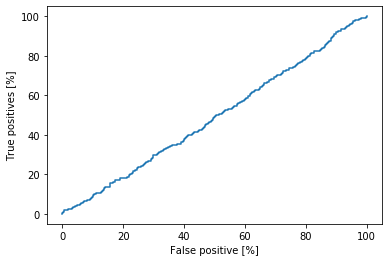

In [30]:
plot_roc(test_labels, test_gen)

Böylelikle sadece metrikleri almadık aynı zamanda roc eğrisini görmüş olduk.

Kaggle'daki [SIIM-ISIC Melanoma Classification](https://www.kaggle.com/c/siim-isic-melanoma-classification/overview) yarışmasındaki train data seti de bizimkiyle aynı, test setini bilmiyoruz ama. 